# Bat Neurobiology step by step redevelopment

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# 1. Setup Parameters
fs = 400000       # Sampling rate: 400 kHz (high enough for ultrasound)
cf_freq = 80000   # CF component: 80 kHz
fm_start = 80000  # FM sweep start: 80 kHz
fm_end = 40000    # FM sweep end: 40 kHz

dur_cf = 0.020    # Duration of CF: 20 ms
dur_fm = 0.005    # Duration of FM: 5 ms

# 2. Generate Time Arrays
t_cf = np.linspace(0, dur_cf, int(fs * dur_cf), endpoint=False)
t_fm = np.linspace(0, dur_fm, int(fs * dur_fm), endpoint=False)

# 3. Generate the Signal Components

# Part A: Constant Frequency (CF) - A simple Sine wave
sig_cf = np.sin(2 * np.pi * cf_freq * t_cf)

# Part B: Frequency Modulated (FM) - A Downward Chirp
# We need the instantaneous phase, which is the integral of frequency
k = (fm_end - fm_start) / dur_fm  # Slope of frequency change
instantaneous_freq = fm_start + k * t_fm
# Phase = integral of (f_start + kt) -> f_start*t + 0.5*k*t^2
phase_fm = 2 * np.pi * (fm_start * t_fm + 0.5 * k * t_fm**2)
sig_fm = np.sin(phase_fm)

# Part C: Combine them
# We concatenate them to make one continuous call
time_full = np.concatenate([t_cf, t_cf[-1] + t_fm]) # shifts FM time to start after CF
signal = np.concatenate([sig_cf, sig_fm])

# Optional: Apply an envelope (tapering) so it doesn't "click" artificially
envelope = np.ones_like(signal)
taper_len = int(fs * 0.001) # 1ms taper
envelope[:taper_len] = np.linspace(0, 1, taper_len)
envelope[-taper_len:] = np.linspace(1, 0, taper_len)
signal = signal * envelope



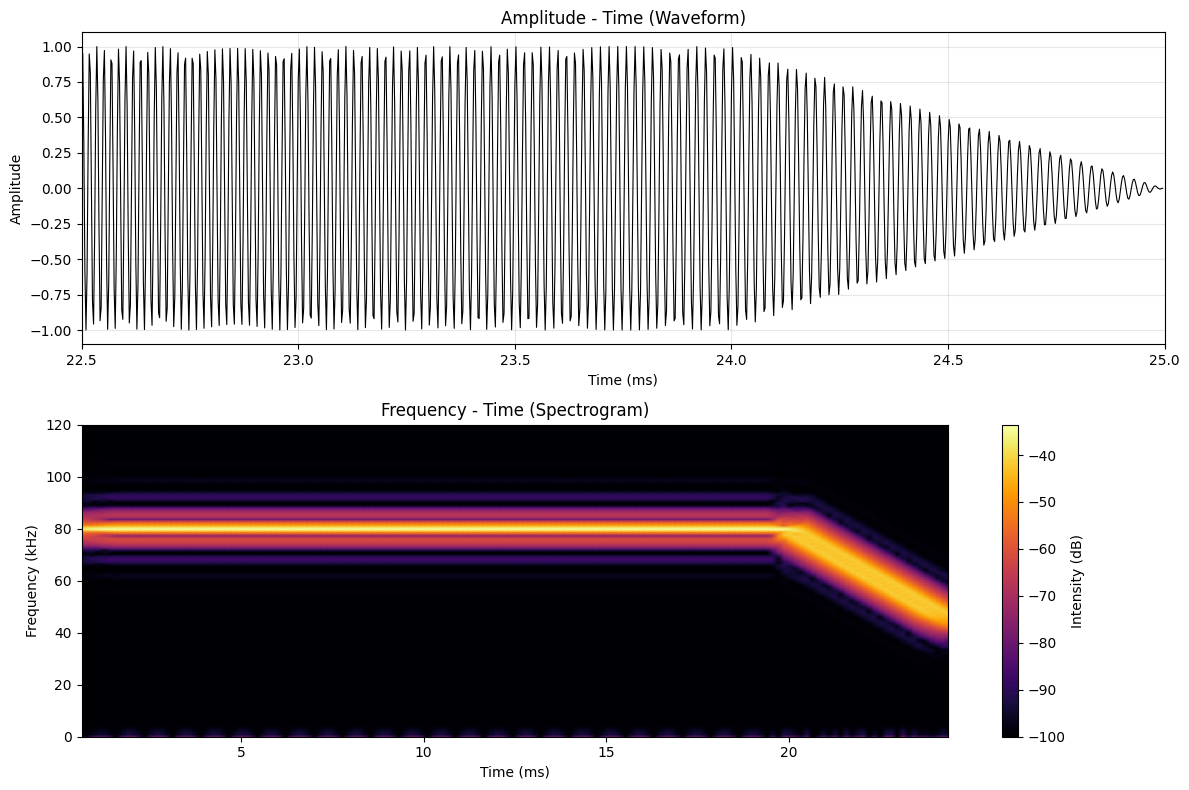

In [7]:
# 4. Plotting
plt.figure(figsize=(12, 8))

# Plot 1: Amplitude vs Time (The Waveform)
plt.subplot(2, 1, 1)
plt.plot(time_full * 1000, signal, color='black', linewidth=0.8) # Convert s to ms
plt.title("Amplitude - Time (Waveform)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.xlim((dur_cf + dur_fm) * 900, (dur_cf + dur_fm) * 1000)

# Plot 2: Frequency vs Time (The Spectrogram)
plt.subplot(2, 1, 2)
f, t, Sxx = spectrogram(signal, fs, nperseg=512, noverlap=450)
plt.pcolormesh(t * 1000, f / 1000, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='inferno')
plt.title("Frequency - Time (Spectrogram)")
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (ms)")
plt.colorbar(label='Intensity (dB)')
plt.ylim(0, 120) # Show 0 to 120 kHz

plt.tight_layout()
plt.show()

In [10]:
import torch
import snntorch as snn
from scipy.signal import butter, lfilter

# --- 1. Define the Physics (The Filters) ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    y = lfilter(b, a, data)
    return y

# Define our 3 Channels corresponding to parts of the bat call
# Channel 1: 80 kHz (Detects the CF component and start of FM)
# Channel 2: 60 kHz (Detects the middle of the FM sweep)
# Channel 3: 40 kHz (Detects the end of the FM sweep)
channels = [
    (75000, 85000), # 80kHz center
    (55000, 65000), # 60kHz center
    (35000, 45000)  # 40kHz center
]

# --- 2. Define the Neurobiology (The Lapicque Neuron) ---
# In biology, the membrane time constant (R*C) determines how "leaky" the neuron is.
# A bat's auditory neurons are very fast (short time constant) to preserve precise timing.
time_step = 1 / fs  # 2.5 microseconds per step
R = 5.0             # Resistance (arbitrary units for simulation)
C = 1e-3            # Capacitance (Very small for fast reaction)

# snnTorch allows us to instantiate the neuron using R and C directly
# This automatically calculates the decay rate 'beta'
lif_neurons = [snn.Lapicque(R=R, C=C, time_step=time_step) for _ in range(3)]

# --- 3. Run the Simulation ---
spike_trains = [[], [], []]
filtered_signals = []

# Prepare the data
# Convert our numpy signal to a PyTorch tensor for the neurons
# We also Rectify the signal (np.abs) because neurons integrate positive current
for i, (low, high) in enumerate(channels):
    # Physics: Filter the audio
    filt = apply_filter(signal, low, high, fs)
    filtered_signals.append(filt)
    
    # Biology: Rectify (Hair Cell) and Convert to Tensor
    # We multiply by 50 to amplify the signal enough to cross the threshold of 1.0
    input_current = torch.tensor(np.abs(filt) * 50).float()
    
    # Run the Neuron over time
    spikes = []
    mem = lif_neurons[i].init_lapicque() # Initialize membrane potential
    
    for t in range(len(input_current)):
        # Pass the current at time 't' into the neuron
        spk, mem = lif_neurons[i](input_current[t], mem) 
        spikes.append(spk.item())
        
    spike_trains[i] = spikes



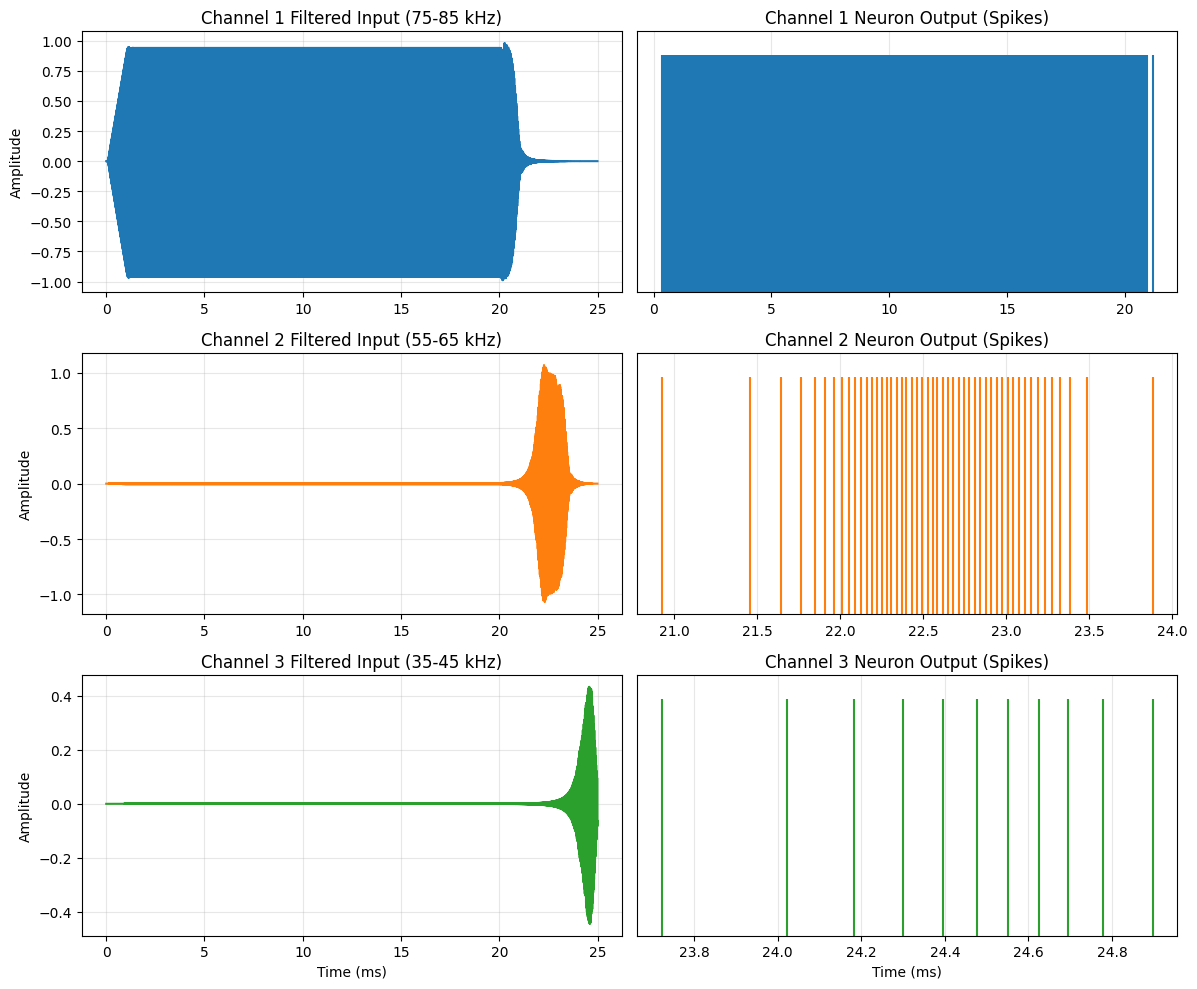

In [11]:
# --- 4. Visualization ---
plt.figure(figsize=(12, 10))

# Plot filtered audio (The Physics)
for i in range(3):
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(time_full*1000, filtered_signals[i], color=f'C{i}')
    plt.title(f"Channel {i+1} Filtered Input ({channels[i][0]//1000}-{channels[i][1]//1000} kHz)")
    plt.ylabel("Amplitude")
    if i == 2: plt.xlabel("Time (ms)")
    plt.grid(True, alpha=0.3)

# Plot Spikes (The Output)
for i in range(3):
    plt.subplot(3, 2, 2*i + 2)
    
    # Draw vertical lines for spikes
    spike_indices = np.where(np.array(spike_trains[i]) > 0)[0]
    plt.vlines(time_full[spike_indices]*1000, 0, 1, color=f'C{i}')
    
    plt.title(f"Channel {i+1} Neuron Output (Spikes)")
    plt.ylim(0, 1.1)
    plt.yticks([])
    if i == 2: plt.xlabel("Time (ms)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

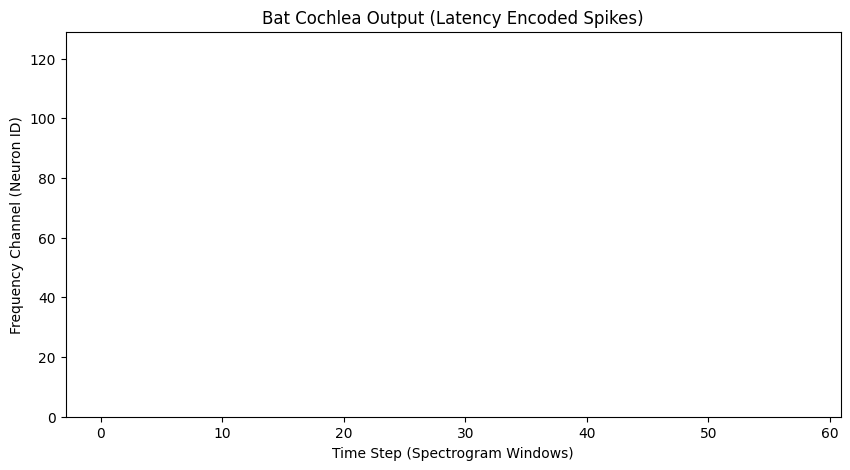

In [ ]:
import torch
import snntorch.spikegen as spikegen
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram

# --- 1. SETUP: Generate the Bat Signal (Same as before) ---
fs = 400000
total_dur = 0.025 # 25ms
t = np.linspace(0, total_dur, int(fs*total_dur))

# Create CF-FM signal
freq_mod = np.linspace(80000, 40000, len(t))
freq_mod[:int(len(t)*0.8)] = 80000 # Keep start constant at 80kHz
phase = 2 * np.pi * np.cumsum(freq_mod) / fs
signal = np.sin(phase) * np.hanning(len(t)) # Apply taper

# --- 2. PRE-PROCESS: Create Spectrogram (The "Ear") ---
# We treat the spectrogram frequency bins as our "Input Neurons"
f, t_spec, Sxx = spectrogram(signal, fs, nperseg=256, noverlap=200)
Sxx_db = 10 * np.log10(Sxx + 1e-10) # Log scale for decibels

# Normalize to 0-1 for the encoder
input_features = torch.tensor(Sxx_db).float()
input_features = (input_features - input_features.min()) / (input_features.max() - input_features.min())

# Dimensions: [Frequency Bins (Neurons) x Time Steps]
# snnTorch expects: [Time x Batch x Neurons]
input_tensor = input_features.T.unsqueeze(1) 

# --- 3. ENCODE: Latency Coding (Native snnTorch) ---
# Loud sounds spike first. Quiet sounds spike later (or not at all).
spike_data = spikegen.latency(input_tensor, tau=5, threshold=0.01, bypass=True)

# --- 4. VISUALIZE: Raster Plot (Native snnTorch) ---
fig, ax = plt.subplots(figsize=(10, 5))

# Use snnTorch's built-in raster plot
# We select the first sample in the batch [:, 0, :]
splt.raster(spike_data[:, 0, :], ax, c="black", marker = "|")

plt.title("Bat Cochlea Output (Latency Encoded Spikes)")
plt.xlabel("Time Step (Spectrogram Windows)")
plt.ylabel("Frequency Channel (Neuron ID)")
plt.ylim(0, 129) # We have 129 frequency bins from the spectrogram
plt.show()

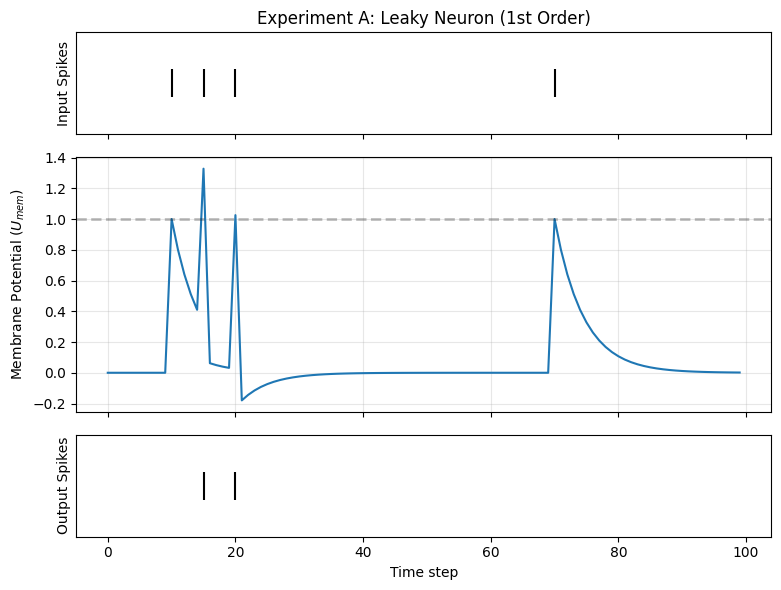

NameError: name 'syn_curr' is not defined